# **Set Up**

In [86]:
import os
import sys
from IPython.display import HTML, display
from sklearn.metrics import silhouette_score


import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from scipy.stats import reciprocal, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.cluster import KMeans


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score
from sklearn import metrics

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [87]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Load Data**

In [88]:
# We now set the directory to access the data
SUMMARY_PATH = '/content/drive/MyDrive/Colab Notebooks/MF815/NLP/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/drive/MyDrive/Colab Notebooks/MF815/NLP/MutualFundLabels.csv'

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

In [89]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/MF815/NLP', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/MF815/NLP', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# **Set up the list of stop words**

In [90]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [91]:
max_features = 5000 # we will only consider the 5000 most frequent words to create the vectors. 
# This value is the size of the vocabulary that we use to vectorize.

In [92]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)

# Tokenizer Functions

In [93]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [94]:
# tokenize the text in all summaries
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

In [95]:
# check test words 
print(text_words[:20])

['ab' 'arizona' 'portfolio' 'investment' 'objective' 'investment'
 'objective' 'portfolio' 'earn' 'highest' 'level' 'current' 'income'
 'exempt' 'federal' 'income' 'tax' 'state' 'arizona' 'personal']


# Skip-Gram Model

In [96]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 3 # The model will go through all the data three times

In [97]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [98]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [99]:
# give a unique id to each words in the vocabulary
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [100]:
# check size of vocabulary
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3449



#Create Data and transform to one-hot representation

In [101]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [102]:
print(data[:20])

[1284, 0, 7, 3, 123, 3, 123, 7, 1085, 289, 471, 181, 26, 563, 77, 26, 61, 264, 0, 1087]


In [103]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

#  generate training patch

In [104]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

# Train the skip-gram Model

In [105]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [106]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [107]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3449)]            0         
                                                                 
 dense_10 (Dense)            (None, 50)                172500    
                                                                 
 dense_11 (Dense)            (None, 3449)              175899    
                                                                 
Total params: 348,399
Trainable params: 348,399
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/3


<ipython-input-108-872bc948d3d9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


7481/7481 [==============================] - 57s 8ms/step - loss: 0.0125
Epoch 2/3
7481/7481 [==============================] - 53s 7ms/step - loss: 0.0021
Epoch 3/3
7481/7481 [==============================] - 54s 7ms/step - loss: 0.0020


#Use the encoder to vectorize

In [109]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [110]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 [==============================] - 0s 29ms/step


In [111]:
# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec)

# Find n closer words

In [112]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [113]:
words_neighbors_1 = get_n_closer('equity', 10, word2vec)
print('words close to equity : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('derivatives', 10, word2vec)
print('words close to derivatives : ' +str(', '.join(words_neighbors_2)))
words_neighbors_3 = get_n_closer('fixed', 10, word2vec)
print('words close to fixed : ' +str(', '.join(words_neighbors_3)))

words close to equity : equity, common, designed, primarily, typically, bond, real, small, includes, municipal
words close to derivatives : derivatives, leverage, loss, difficult, collateral, instrument, instruments, significant, heightened, highly
words close to fixed : fixed, combination, preservation, personal, gross, distribute, concerning, regarding, left, code


# Create knowledge base

In [114]:
# create the knowledge base for each type
balanced_kb = ['balance', 'balanced', 'asset','allocation','hybrid','basket','security','bond','equity','mix','combination','fund','rebalance','diversify']
               
fixed_kb = ['fixed', 'long','principal','coupon','yield','bond','premium','income','interest','rate','derivatives','derivative','maturities','yields']

equity_kb = ['index', 'shareholder', 'stock', 'equity', 'asset','liability', 'growth', 'value' , 'capital', 'technology', 'shares','dividend', 'income', 'growth']

longshort_kb = ['long','short','leverage', 'hedge', 'risk', 'margin', 'neutral', 'fee', 'spread', 'turnover', 'illiquid', 'management', 'relative','margin']

In [115]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [116]:
keywords_list = [balanced_kb,fixed_kb,equity_kb,longshort_kb]

knowledge_base = []
for keywords in keywords_list:
  knowledge_base.append(create_knowledge_base(5, word2vec, keywords))

diversify not in word2vec


In [117]:
print(knowledge_base[0])

{'rebalance', 'combination', 'allocation', 'decrease', 'mix', 'transact', 'balanced', 'though', 'typically', 'gross', 'linked', 'preservation', 'primarily', 'category', 'exclude', 'april', 'allocations', 'fluctuate', 'portfolios', 'morgan', 'subsequently', 'controlled', 'diversify', 'bond', 'automatically', 'request', 'results', 'affect', 'fund', 'emphasizes', 'redeems', 'delay', 'correspond', 'rebalancing', 'remember', 'china', 'hybrid', 'sampling', 'asset', 'standardized', 'security', 'designed', 'appreciate', 'universe', 'joining', 'derived', 'blended', 'go', 'difficult', 'common', 'balance', 'majority', 'establish', 'closely', 'specialty', 'basket', 'lipper', 'sound', 'j.p.', 'equity', 'start', 'global', 'small', 'head', 'intervention', 'recapture'}


# Scoring function

In [118]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [119]:
#check the prediction style
df['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          247
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: Ivestment Strategy, dtype: int64

In [120]:
#drop Commodities Fund (Low Risk), as it only appear once in the whole data set
df = df[df['Ivestment Strategy'] != 'Commodities Fund (Low Risk)']

In [121]:
#return the sum of sentence scores for each catgorical
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return np.sum(sentence_scores)

In [122]:
df['balance_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base[0], num_sent=5), axis=1)
df['fixed_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base[1], num_sent=5), axis=1)
df['equity_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base[2], num_sent=5), axis=1)
df['longshort_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base[3], num_sent=5), axis=1)

In [123]:
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary,balance_sentences_match,fixed_sentences_match,equity_sentences_match,longshort_sentences_match
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...,131,106,89,52
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...,140,118,107,55
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...,136,114,105,52
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...,131,102,98,50
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...,131,102,98,50


#Pre-process data

In [177]:
#transfer the strategy category to the startegy code and make sure Long Short Funds (High Risk) allocating to train and test sets
low_risk = df[df['Ivestment Strategy'] != 'Long Short Funds (High Risk)']
X_low_risk = low_risk[['balance_sentences_match','fixed_sentences_match','equity_sentences_match', 'longshort_sentences_match']]
low_risk['Ivestment Strategy code'] = low_risk['Ivestment Strategy'].astype('category').cat.codes
y_low_risk = low_risk['Ivestment Strategy code'].values
X_train_low_risk, X_test_low_risk, y_train_low_risk, y_test_low_risk = train_test_split(X_low_risk, y_low_risk, test_size = 0.2, random_state=21)
high_risk = df[df['Ivestment Strategy'] == 'Long Short Funds (High Risk)']
X_high_risk = high_risk[['balance_sentences_match','fixed_sentences_match','equity_sentences_match', 'longshort_sentences_match']]
y_high_risk = [3,3,3,3]
X_train_high_risk, X_test_high_risk, y_train_high_risk, y_test_high_risk = train_test_split(X_high_risk, y_high_risk, test_size = 0.2, random_state=42)
X_train = pd.concat([X_train_high_risk,X_train_low_risk]).values
X_test = pd.concat([X_test_high_risk,X_test_low_risk]).values
y_train = np.concatenate([y_train_high_risk, y_train_low_risk])
y_test = np.concatenate([y_test_high_risk, y_test_low_risk])
y_train = np.concatenate([y_train_high_risk, y_train_low_risk])
y_test = np.concatenate([y_test_high_risk, y_test_low_risk])

<ipython-input-177-345e79d2de6a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk['Ivestment Strategy code'] = low_risk['Ivestment Strategy'].astype('category').cat.codes


# Logistics Regression

In [178]:
lm = LogisticRegression(multi_class='auto', solver='liblinear', max_iter=100)
lm.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [179]:
lm_predictions = lm.predict(X_test)

In [180]:
print(classification_report(y_test,lm_predictions))

              precision    recall  f1-score   support

           0       0.88      0.44      0.58        16
           1       0.78      0.89      0.83        53
           2       0.65      0.71      0.68        24
           3       0.00      0.00      0.00         1

    accuracy                           0.76        94
   macro avg       0.58      0.51      0.52        94
weighted avg       0.76      0.76      0.74        94



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [181]:
print(confusion_matrix(y_test,lm_predictions))

[[ 7  6  3  0]
 [ 0 47  6  0]
 [ 1  6 17  0]
 [ 0  1  0  0]]


#Random Forest

In [182]:
param_grid_rnd = {'max_leaf_nodes':[15, 20, 25], 'min_samples_leaf': [6, 10, 17], 'max_depth':[9, 12, 15]}
rnd_clf = RandomForestClassifier()
grid_rnd = RandomizedSearchCV(estimator = rnd_clf, param_distributions = param_grid_rnd, scoring= 'accuracy',cv=3)
grid_search_rnd = grid_rnd.fit(X_train,y_train)

In [183]:
rnd_predictions = grid_search_rnd.best_estimator_.predict(X_test)
print(classification_report(y_test,rnd_predictions))

              precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.90      0.89      0.90        53
           2       0.70      0.88      0.78        24
           3       0.00      0.00      0.00         1

    accuracy                           0.84        94
   macro avg       0.63      0.61      0.61        94
weighted avg       0.84      0.84      0.84        94



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
print(confusion_matrix(y_test,rnd_predictions))

[[11  1  4  0]
 [ 1 47  5  0]
 [ 0  3 21  0]
 [ 0  1  0  0]]


#DNN

In [225]:
def create_DNN_model():
  model = Sequential()

  model.add(Dense(64, input_dim=4, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [226]:
DNN_model = create_DNN_model()

In [227]:
X_train_d, X_val, y_train_d, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=16)

In [228]:
DNN_history = DNN_model.fit(X_train_d, y_train_d, validation_data=(X_val, y_val), epochs=200, batch_size=16)

Epoch 1/200
19/19 [==============================] - 2s 20ms/step - loss: 28.0651 - accuracy: 0.2838 - val_loss: 8.5177 - val_accuracy: 0.4533
Epoch 2/200
19/19 [==============================] - 0s 5ms/step - loss: 19.9183 - accuracy: 0.3682 - val_loss: 7.1775 - val_accuracy: 0.4667
Epoch 3/200
19/19 [==============================] - 0s 5ms/step - loss: 15.9680 - accuracy: 0.4020 - val_loss: 5.4846 - val_accuracy: 0.5867
Epoch 4/200
19/19 [==============================] - 0s 5ms/step - loss: 12.7660 - accuracy: 0.4122 - val_loss: 3.6309 - val_accuracy: 0.6667
Epoch 5/200
19/19 [==============================] - 0s 5ms/step - loss: 10.5161 - accuracy: 0.4054 - val_loss: 2.9867 - val_accuracy: 0.6667
Epoch 6/200
19/19 [==============================] - 0s 6ms/step - loss: 7.6750 - accuracy: 0.4324 - val_loss: 1.8715 - val_accuracy: 0.6800
Epoch 7/200
19/19 [==============================] - 0s 6ms/step - loss: 6.9919 - accuracy: 0.4899 - val_loss: 1.7071 - val_accuracy: 0.6533
Epoch 8

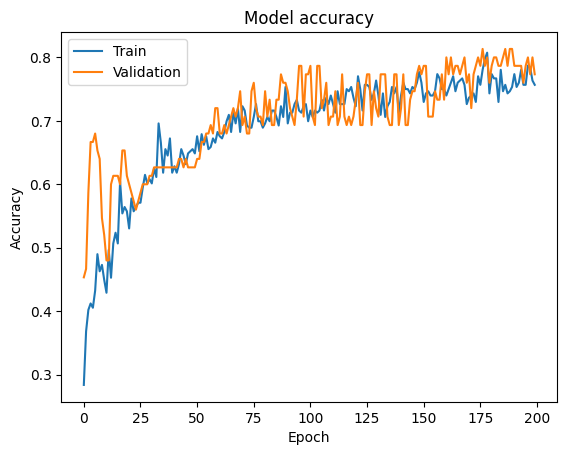

In [229]:
# Plot training & validation accuracy values
plt.plot(DNN_history.history['accuracy'])
plt.plot(DNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

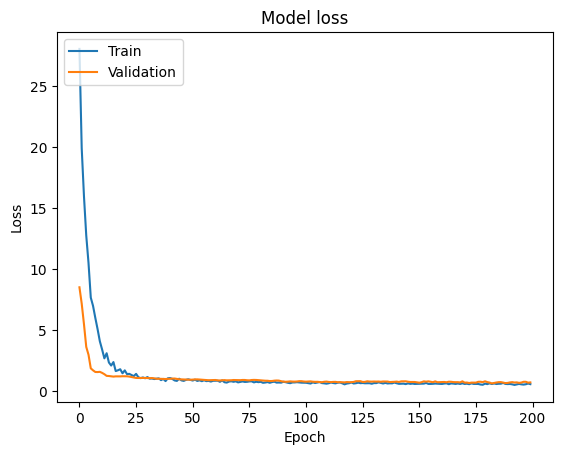

In [230]:
# Plot training & validation loss values
plt.plot(DNN_history.history['loss'])
plt.plot(DNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [231]:
DNN_prob = DNN_model.predict(X_test)
DNN_predictions = np.array([list(x).index(max(x)) for x in DNN_prob])
print(classification_report(y_test,DNN_predictions))

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.78      0.44      0.56        16
           1       0.79      0.92      0.85        53
           2       0.83      0.79      0.81        24
           3       0.00      0.00      0.00         1

    accuracy                           0.80        94
   macro avg       0.60      0.54      0.56        94
weighted avg       0.79      0.80      0.78        94



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [232]:
print(confusion_matrix(y_test,DNN_predictions))

[[ 7  7  2  0]
 [ 2 49  2  0]
 [ 0  5 19  0]
 [ 0  1  0  0]]
